In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV



In [2]:
#load in data
df = pd.read_csv("cardio_train.csv", sep=";")

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
# bp is 1 - 5 where 1 is Normal, 2 is Elevated, 3 is HyperTension Stage1, 4 is HyperTensions Stage2, 5 is Hypertension Stage3
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2


# Train Test Splitting

In [3]:
#our target variable is cardio
y = df['cardio'].values
X = df.drop(['id', 'cardio'], axis=1).values

#make CV spit 80/20 object
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         


# All kinds of trees

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
     ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators))
]
for clf in clf_array:
    acc = cross_val_score(clf[1],X,y,cv=3)
    print (clf[0], acc.mean())

Stump 0.7005447000527442
Tree 0.6181930442200504
Random Trees 0.6961151243291824
Extra Random Trees 0.685314622206354
Boosted Tree 0.7224473218364276


# Base model: stump

In [5]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

In [6]:
for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    acc = mt.accuracy_score(y_test, y_hat)
    print(acc)

0.7033267364056168
0.7068136839129205
0.7057770238431816


## What's in the stump? ap_hi.

In [7]:
clf.feature_importances_

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
pd.Series(clf.feature_importances_, index=df.drop(['id', 'cardio'], axis=1).columns)

age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          1.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
bp             0.0
bmi            0.0
dtype: float64

# Finding Best Tree Depth

In [45]:
#first pass over finding best tree depth
param_grid = [
  {'max_depth': [1, 2, 5, 10, 20]}
 ]

tree = DecisionTreeClassifier(min_samples_leaf=1)
clf = GridSearchCV(tree, param_grid, scoring="f1",cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.741866 using {'max_depth': 5}
0.715787 (0.000700) with: {'max_depth': 1}
0.715787 (0.000700) with: {'max_depth': 2}
0.741866 (0.001399) with: {'max_depth': 5}
0.741669 (0.003808) with: {'max_depth': 10}
0.698036 (0.003665) with: {'max_depth': 20}


In [47]:

param_grid = [
  {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11]}
 ]

tree = DecisionTreeClassifier(min_samples_leaf=1)
clf = GridSearchCV(tree, param_grid, scoring="f1",cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.750934 using {'max_depth': 4}
0.735580 (0.000575) with: {'max_depth': 3}
0.750934 (0.000830) with: {'max_depth': 4}
0.739829 (0.004009) with: {'max_depth': 5}
0.735710 (0.002497) with: {'max_depth': 6}
0.745072 (0.004087) with: {'max_depth': 7}
0.747454 (0.001245) with: {'max_depth': 8}
0.744808 (0.003953) with: {'max_depth': 9}
0.740619 (0.002016) with: {'max_depth': 10}
0.738614 (0.001016) with: {'max_depth': 11}


# Random Forest with 6 depth

In [44]:
clf = RandomForestClassifier(max_depth=6, n_estimators=num_estimators)

for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    acc = mt.f1_score(y_test, y_hat)
    print(acc)

0.7397694270879169
0.7395815016704765
0.7401229148375769


# Random Search

In [10]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 8]
# Maximum number of levels in tree
max_depth = [4, 8, 12]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [12]:
clf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 134.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 695.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 8, 12, None],
                                        'max_features': ['log2', 'sqrt', 8],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [15]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=12, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=1800)

In [16]:
yhat = rf_random.best_estimator_.predict(X_test)
f1 = mt.f1_score(y_test, yhat)
print(f1)

0.754813863928113


In [17]:
rf_random.best_estimator_.feature_importances_

array([0.14488406, 0.00731185, 0.04512217, 0.05216669, 0.28804637,
       0.09480762, 0.07362087, 0.01460951, 0.00701458, 0.00551561,
       0.01092071, 0.18251484, 0.07346512])

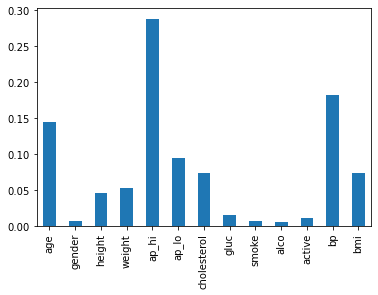

In [18]:
features = pd.Series(rf_random.best_estimator_.feature_importances_, index=df.drop(['id', 'cardio'], axis=1).columns)
features.plot(kind='bar')
plt.show()

# Grid Search

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [4, 8, 12],
    'max_features': [2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000, 1800]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)